# Importing needed libraries

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
import time
import datetime
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from scipy.cluster import hierarchy
from sklearn.cluster import DBSCAN

# Reading the CSV file

In [3]:
data=pd.read_csv('bank_transactions.csv')
data.head(3)

TransactionID CustomerID CustomerDOB CustGender CustLocation  \
0            T1   C5841053     10/1/94          F   JAMSHEDPUR   
1            T2   C2142763      4/4/57          M      JHAJJAR   
2            T3   C4417068    26/11/96          F       MUMBAI   

   CustAccountBalance TransactionDate  TransactionTime  \
0            17819.05          2/8/16           143207   
1             2270.69          2/8/16           141858   
2            17874.44          2/8/16           142712   

   TransactionAmount (INR)  
0                     25.0  
1                  27999.0  
2                    459.0

# Exploring and cleaning the data

Shape of the dataframe :

In [4]:
shape = data.shape
df_shape = pd.DataFrame({'Rows': [shape[0]], 'Columns': [shape[1]]})
print(df_shape)

      Rows  Columns
0  1048567        9


In [5]:
li=[]
columns=data.columns
for column in columns:
    dtypes=data[column].dtypes
    sum_null=data[column].isnull().sum()
    li.append([column,dtypes,sum_null])
check=pd.DataFrame(li)
check.columns=['column','dtypes','sum_null']
check    

column   dtypes  sum_null
0            TransactionID   object         0
1               CustomerID   object         0
2              CustomerDOB   object      3397
3               CustGender   object      1100
4             CustLocation   object       151
5       CustAccountBalance  float64      2369
6          TransactionDate   object         0
7          TransactionTime    int64         0
8  TransactionAmount (INR)  float64         0

As shown above, in addition to having some null values, we have multiple categorical data that we need to convert to numerical data to use in clustering later.

We need to check the ratio of missing values in each column to see if we can drop the rows of these missing values.

In [6]:
print(data.isnull().sum()/ len(data)*100)

TransactionID              0.000000
CustomerID                 0.000000
CustomerDOB                0.323966
CustGender                 0.104905
CustLocation               0.014401
CustAccountBalance         0.225927
TransactionDate            0.000000
TransactionTime            0.000000
TransactionAmount (INR)    0.000000
dtype: float64


Refering to the above output, the ratio of the missing values in each feature is very low , so we can drop the rows with these missing values.

In [7]:
data.dropna(inplace=True)
data.isnull().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

In [8]:
print(data.duplicated().sum())

0


There is no duplicate rows.

In [9]:
data.describe(include='all')

TransactionID CustomerID CustomerDOB CustGender CustLocation  \
count        1041614    1041614     1041614    1041614      1041614   
unique       1041614     879358       17233          3         9275   
top               T1   C5533885    1/1/1800          M       MUMBAI   
freq               1          6       56292     760978       101997   
mean             NaN        NaN         NaN        NaN          NaN   
std              NaN        NaN         NaN        NaN          NaN   
min              NaN        NaN         NaN        NaN          NaN   
25%              NaN        NaN         NaN        NaN          NaN   
50%              NaN        NaN         NaN        NaN          NaN   
75%              NaN        NaN         NaN        NaN          NaN   
max              NaN        NaN         NaN        NaN          NaN   

        CustAccountBalance TransactionDate  TransactionTime  \
count         1.041614e+06         1041614     1.041614e+06   
unique                 NaN              55              NaN   
top                    NaN          7/8/16              NaN   
freq                   NaN           27084              NaN   
mean          1.149986e+05             NaN     1.571221e+05   
std           8.467609e+05             NaN     5.126352e+04   
min           0.000000e+00             NaN     0.000000e+00   
25%           4.728140e+03             NaN     1.240410e+05   
50%           1.676852e+04             NaN     1.642470e+05   
75%           5.742885e+04             NaN     2.000220e+05   
max           1.150355e+08             NaN     2.359590e+05   

        TransactionAmount (INR)  
count              1.041614e+06  
unique                      NaN  
top                         NaN  
freq                        NaN  
mean               1.566096e+03  
std                6.561464e+03  
min                0.000000e+00  
25%                1.600000e+02  
50%                4.575000e+02  
75%                1.200000e+03  
max                1.560035e+06

In [10]:
data['CustGender'].value_counts()

M    760978
F    280635
T         1
Name: CustGender, dtype: int64

In [11]:
data.drop((data[data['CustGender']=='T']).index , inplace=True)

While observing the DOB column there were some dates with the following format (dd-mm-yy) , so we need to make it as (dd-mm-yyyy) format.

In [12]:
def fix_year(date_str):
    parts = date_str.split('/')
    if len(parts[2]) == 2:
        parts[2] = '19' + parts[2]  
    return '/'.join(parts)

data['CustomerDOB'] = data['CustomerDOB'].apply(fix_year)

Converting the type of columns TransactionDate,CustomerDOB from string to datetime.

In [13]:
data['CustomerDOB'] = pd.to_datetime(data['CustomerDOB'],format='%d/%m/%Y')
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])

Deleting rows with DOB =1800

In [14]:
data = data[data['CustomerDOB'].dt.year != 1800]

Calculating customers age (transaction date - customer DOB)

In [15]:
data['CustomerAge'] = (data['TransactionDate'].dt.year - data['CustomerDOB'].dt.year)

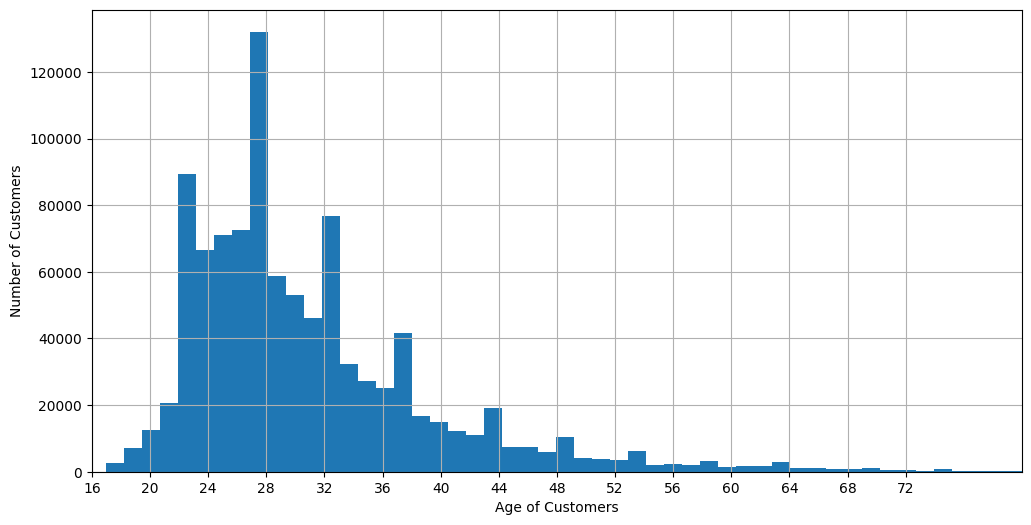

In [16]:
fig, axs = plt.subplots(1, figsize=(12, 6), sharey=True)
data['CustomerAge'].hist(ax=axs, bins=80)
axs.set_xlabel("Age of Customers")
axs.set_ylabel("Number of Customers")
age_bins = list(range(16, 76, 4))  
axs.set_xticks(age_bins)
axs.set_xlim(16, 80) 
plt.show()

The figure above shows how the majority of customers range between the age of 20 and 50.

Dropping unneeded columns.

In [17]:
data.drop(columns=['TransactionID', 'CustomerDOB' ] ,axis=1 , inplace = True  )

# RFM Analysis

Calculating Monetary.

In [18]:
monetary = data.groupby('CustomerID')['TransactionAmount (INR)'].sum() 
mon= monetary.reset_index() 
mon.columns = ['CustomerID', 'Monetary' ]
mon 

CustomerID  Monetary
0        C1010011    5106.0
1        C1010012    1499.0
2        C1010014    1455.0
3        C1010018      30.0
4        C1010024    5000.0
...           ...       ...
839076   C9099836     691.0
839077   C9099877     222.0
839078   C9099919     126.0
839079   C9099941      50.0
839080   C9099956     855.0

[839081 rows x 2 columns]

.

Calculating Frequency.

In [19]:
frequency= data.groupby('CustomerID')['TransactionAmount (INR)'].count()
fre = frequency.reset_index()
fre.columns = ['CustomerID', 'Frequency']
fre.head()

CustomerID  Frequency
0   C1010011          2
1   C1010012          1
2   C1010014          2
3   C1010018          1
4   C1010024          1

.

Calculating Recency.

In [20]:
# Computing the maximum date to know the last transaction date
max_date = max(data['TransactionDate'])
# Computing the difference between max date and transaction date
data['difference'] = (max_date - data['TransactionDate']).dt.days
# Computing last transaction date to get the recency of customers
recency = data.groupby('CustomerID')['difference'].min()
rec = recency.reset_index()
rec.head(8)

CustomerID  difference
0   C1010011          74
1   C1010012         117
2   C1010014         154
3   C1010018          85
4   C1010024         113
5   C1010028         102
6   C1010031         245
7   C1010035         104

.

Merging the RFM columns with the main data set.

In [21]:
rfm = pd.merge(mon, fre, on='CustomerID', how='inner')
rfm = pd.merge(rfm, rec, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Monetary', 'Frequency', 'Recency (days)']
df  = pd.merge(data, rfm , on='CustomerID', how='inner') 
df.drop(columns=[  'CustomerID','difference'], inplace= True  , axis=1 )
df.drop_duplicates(inplace= True )
df.head()

CustGender CustLocation  CustAccountBalance TransactionDate  \
0          F   JAMSHEDPUR            17819.05      2016-02-08   
1          M      JHAJJAR             2270.69      2016-02-08   
2          F       MUMBAI            17874.44      2016-02-08   
3          F       MUMBAI           866503.21      2016-02-08   
4          M       MUMBAI             3195.78      2016-08-13   

   TransactionTime  TransactionAmount (INR)  CustomerAge  Monetary  Frequency  \
0           143207                     25.0           22      25.0          1   
1           141858                  27999.0           59   27999.0          1   
2           142712                    459.0           20     459.0          1   
3           142714                   2060.0           43    2938.4          2   
4           194148                    878.4           37    2938.4          2   

   Recency (days)  
0             305  
1             305  
2             305  
3             118  
4             118

In [22]:
df.describe()

CustAccountBalance  TransactionTime  TransactionAmount (INR)  \
count        9.853100e+05    985310.000000             9.853100e+05   
mean         1.060608e+05    157434.801386             1.452416e+03   
std          8.179098e+05     51270.506213             6.139764e+03   
min          0.000000e+00         0.000000             0.000000e+00   
25%          4.581878e+03    124242.000000             1.510000e+02   
50%          1.600466e+04    164625.500000             4.310000e+02   
75%          5.375908e+04    200151.000000             1.125000e+03   
max          1.150355e+08    235959.000000             1.560035e+06   

         CustomerAge      Monetary      Frequency  Recency (days)  
count  985310.000000  9.853100e+05  985310.000000   985310.000000  
mean       31.119943  1.938379e+03       1.335527      123.274730  
std         9.075805  7.020430e+03       0.591808       77.915753  
min        17.000000  0.000000e+00       1.000000        0.000000  
25%        25.000000  2.100000e+02       1.000000       85.000000  
50%        29.000000  6.069000e+02       1.000000      107.000000  
75%        34.000000  1.663000e+03       2.000000      123.000000  
max       116.000000  1.560035e+06       6.000000      336.000000

# Data Analysis and Visualization

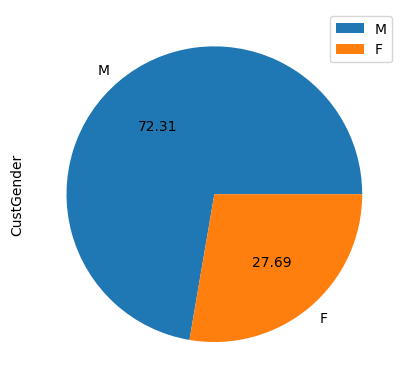

In [23]:
data['CustGender'].value_counts().plot(kind='pie',autopct='%.2f')
plt.legend()
plt.show()

Location Analysis.

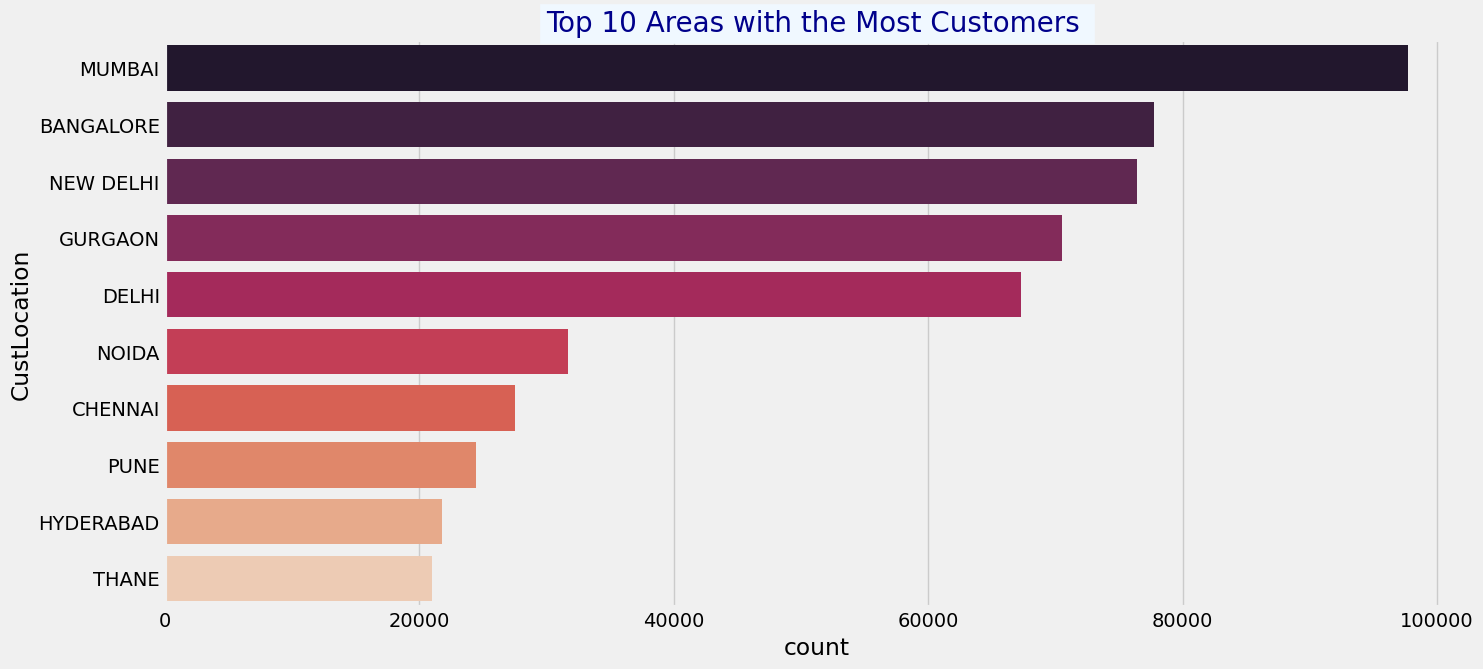

In [24]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,7))
chart=sns.countplot(y='CustLocation',data=df,palette='rocket', order = df['CustLocation'].value_counts()[:10].index)
plt.title("Top 10 Areas with the Most Customers ",
          fontsize='20',
          backgroundcolor='AliceBlue',
          color='darkblue');

C:\Users\96279\AppData\Local\Temp\ipykernel_22984\1399881938.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(y=df.groupby('CustLocation')['CustAccountBalance'].max().sort_values(ascending=False)[:10].index ,
C:\Users\96279\AppData\Local\Temp\ipykernel_22984\1399881938.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(y=df.groupby('CustLocation')['TransactionAmount (INR)'].max().sort_values(ascending=False)[:10].index ,


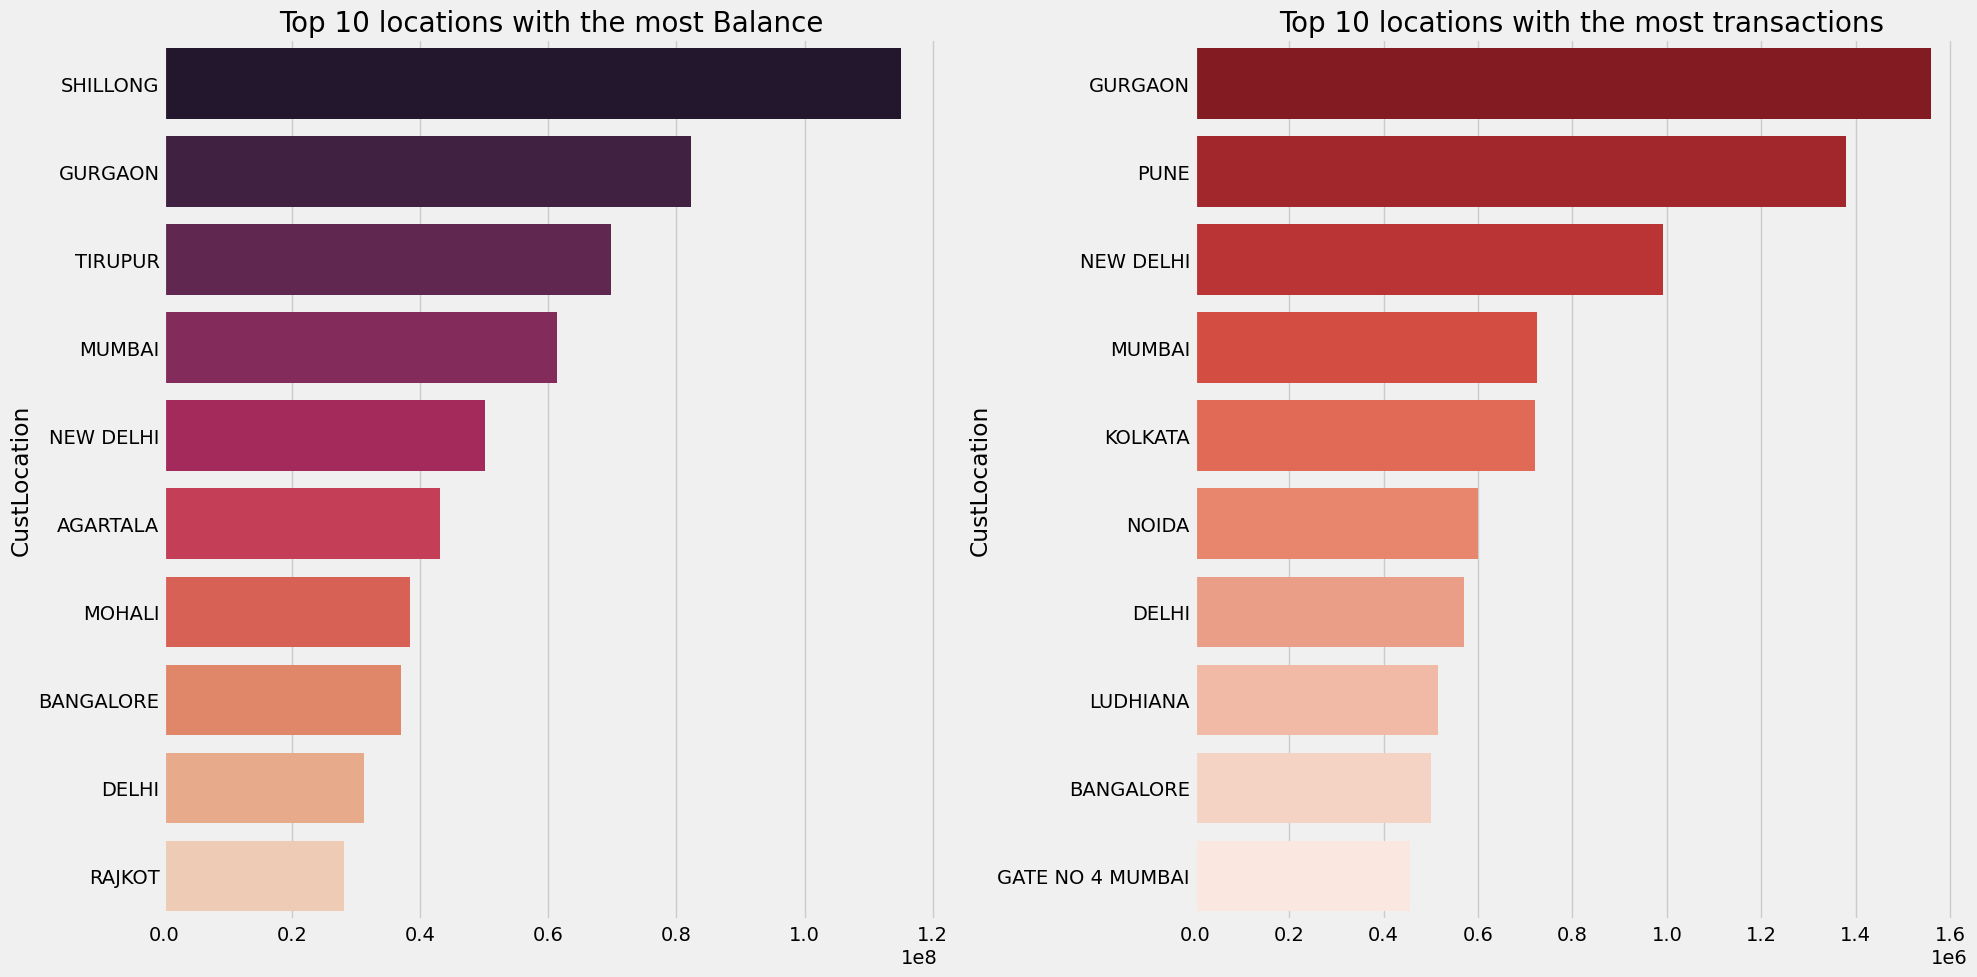

In [25]:
fig ,(ax1,ax2) = plt.subplots(nrows=1 , ncols=2 ,figsize=(20,10))

ax = sns.barplot(y=df.groupby('CustLocation')['CustAccountBalance'].max().sort_values(ascending=False)[:10].index ,
                x= df.groupby('CustLocation')['CustAccountBalance'].max().sort_values(ascending=False)[:10].values,
                ci=None,palette='rocket',ax=ax1)

ax.set_title('Top 10 locations with the most Balance',
          fontsize='20',
          color='black');

ax = sns.barplot(y=df.groupby('CustLocation')['TransactionAmount (INR)'].max().sort_values(ascending=False)[:10].index ,
                x= df.groupby('CustLocation')['TransactionAmount (INR)'].max().sort_values(ascending=False)[:10].values,
                ci=None,palette='Reds_r',ax=ax2)


ax.set_title('Top 10 locations with the most transactions',
         fontsize='20',
          color='black');


plt.tight_layout();

Text(0.5, 0.98, 'Recency and Frequency Analysis')

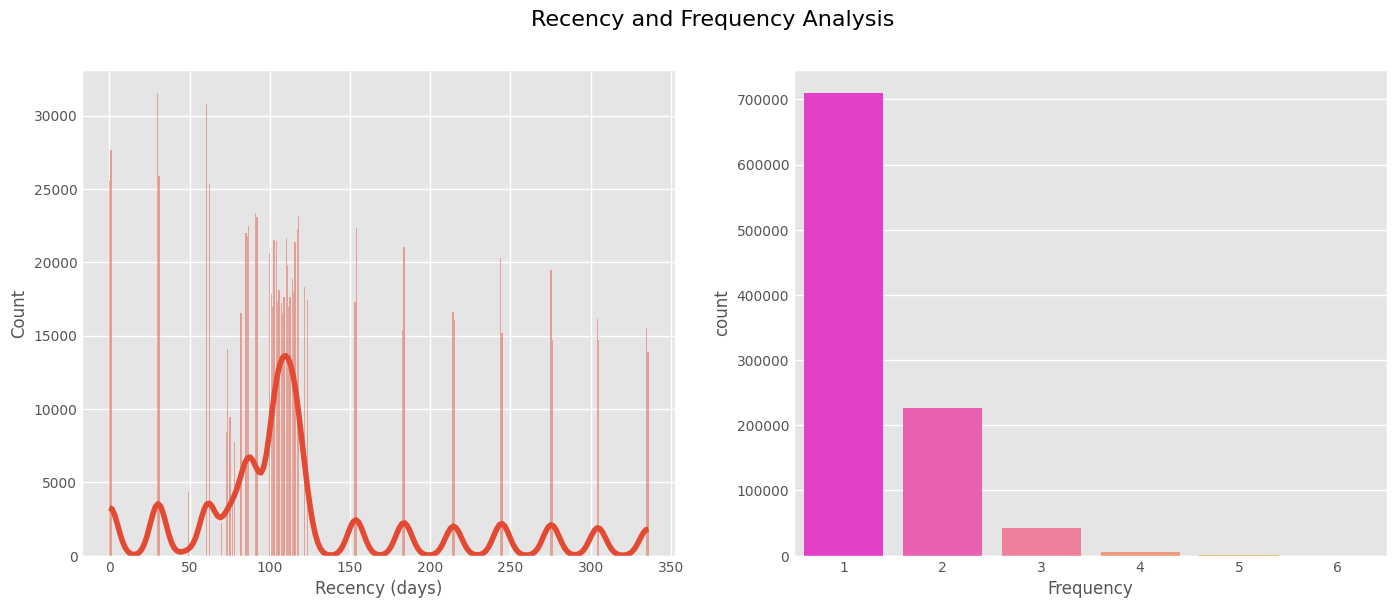

In [26]:
plt.style.use('ggplot')
fig , (ax1,ax2) = plt.subplots(nrows = 1 , ncols = 2, figsize=(15,6))
ax = sns.histplot(df['Recency (days)'],ax=ax1 ,kde=True )
ax = sns.countplot(data=df,x='Frequency', order = df['Frequency'].value_counts().index,palette='spring',ax=ax2)
fig.suptitle('Recency and Frequency Analysis', fontsize=16, ha='center')

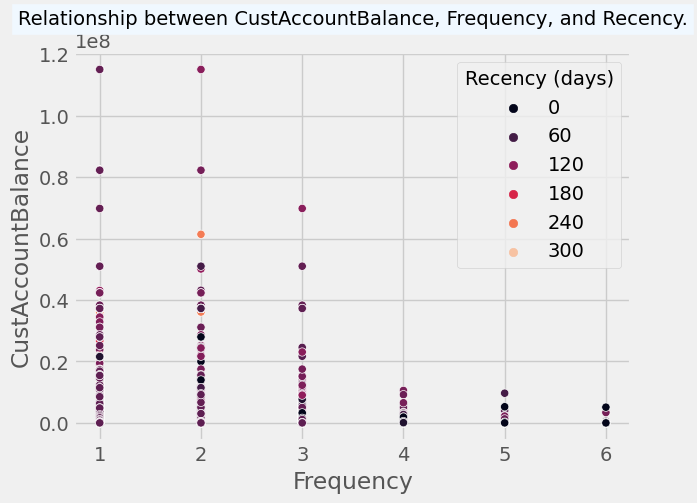

In [27]:
plt.style.use("fivethirtyeight")
sns.scatterplot(x='Frequency', y='CustAccountBalance', data=df, hue='Recency (days)', palette='rocket')
plt.title("Relationship between CustAccountBalance, Frequency, and Recency.",
          fontsize=14, backgroundcolor='AliceBlue', color='black')
plt.show()

C:\Users\96279\AppData\Local\Temp\ipykernel_22984\3042649334.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax1= sns.barplot(
C:\Users\96279\AppData\Local\Temp\ipykernel_22984\3042649334.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax2= sns.barplot(


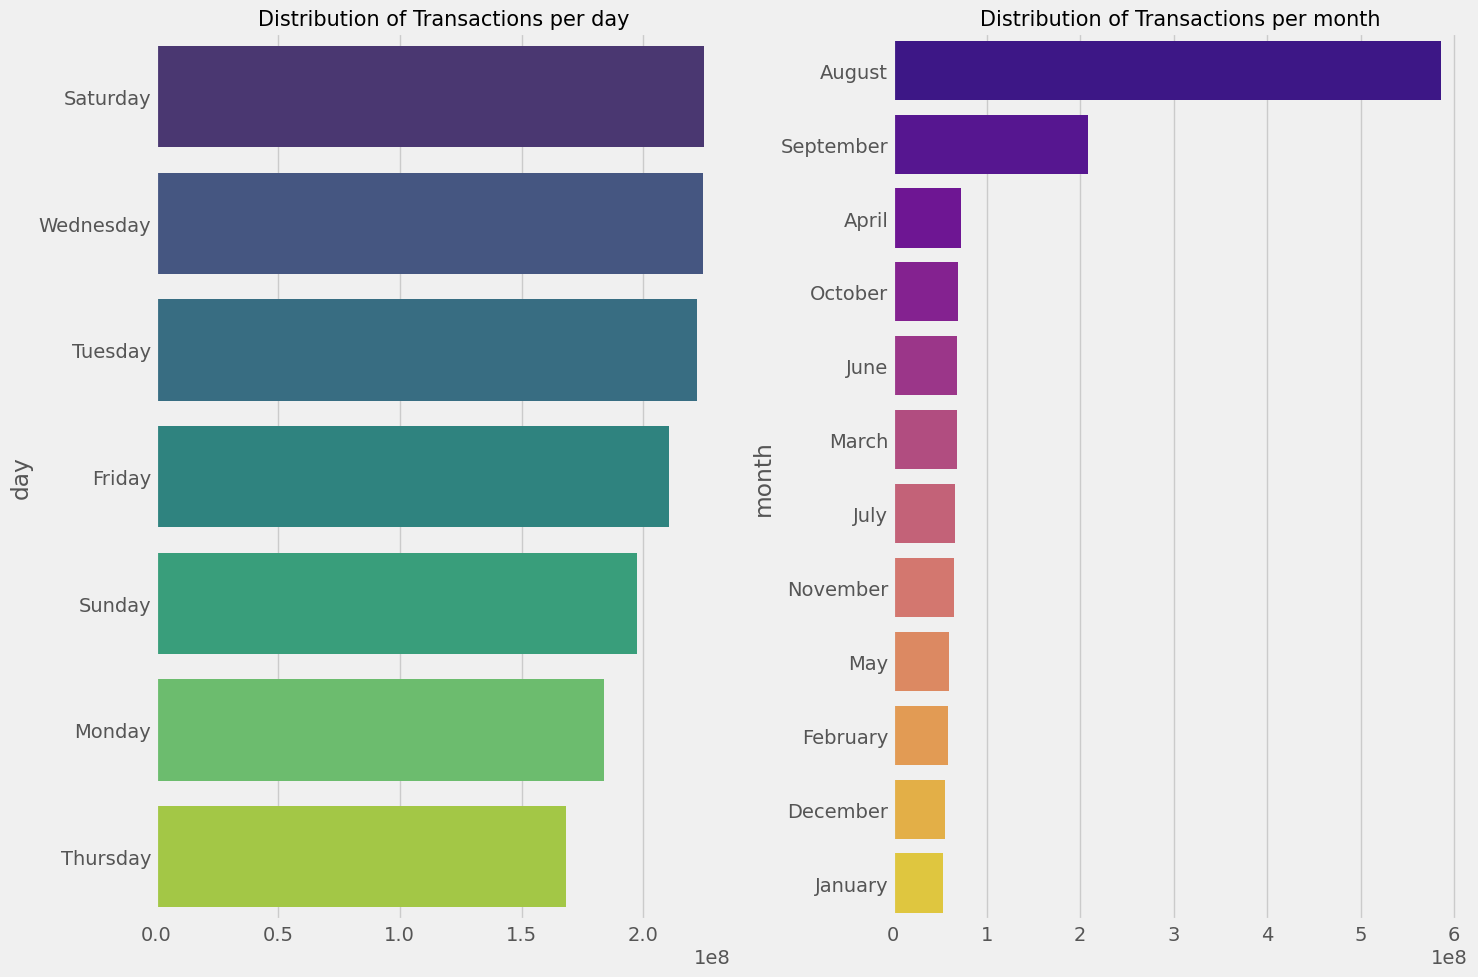

In [28]:
df['day'] = df['TransactionDate'].dt.day_name()
df['month'] = df['TransactionDate'].dt.month_name()

fig,(ax1,ax2)=plt.subplots(ncols=2,nrows=1,figsize=(15,10))

ax1= sns.barplot(  
          x = df.groupby('day')['TransactionAmount (INR)'].sum().sort_values(ascending=False).values, 
          y= df.groupby('day')['TransactionAmount (INR)'].sum().sort_values(ascending=False).index ,
          ci=None,palette='viridis' , ax=ax1
         )
    
ax1.set_title("Distribution of Transactions per day",size = 15, color='black')


ax2= sns.barplot(  
          x = df.groupby('month')['TransactionAmount (INR)'].sum().sort_values(ascending=False).values, 
          y= df.groupby('month')['TransactionAmount (INR)'].sum().sort_values(ascending=False).index,
          ci=None,palette='plasma' ,ax= ax2
         )

ax2.set_title("Distribution of Transactions per month" , size = 15, color='black' )

plt.tight_layout();

In [29]:
periods=[int(datetime.datetime.fromtimestamp(i).strftime("%H")) for i in df.TransactionTime.values]

time = []
for i in periods:
    if i >=0 and i < 13:
        time.append("Morning")
    elif i >= 13 and i<=17:
        time.append("Afternoon")
    elif i > 17 and i <= 19:
        time.append("Evening")
    elif i > 19:
        time.append("Night")
df['tr_pr'] = time

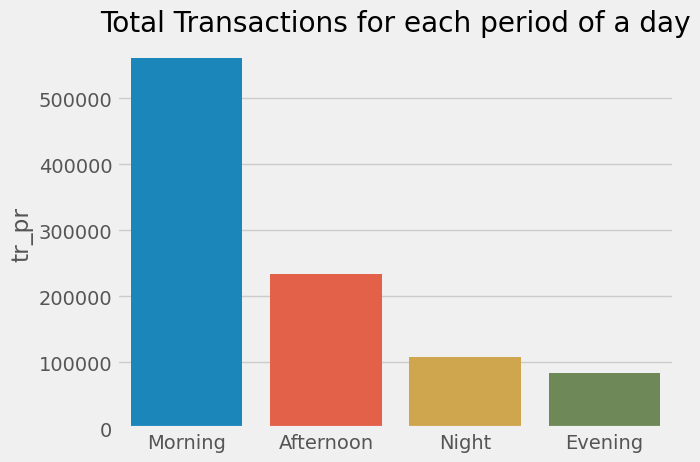

In [30]:
sns.barplot(x=df['tr_pr'].value_counts().keys(), y=df['tr_pr'].value_counts())
plt.title("Total Transactions for each period of a day")
plt.show()

# Data Preproccesing

Dropping uneeded columns that will not be beneficial for clustering.

In [31]:
data= df.drop(columns=['CustLocation','TransactionDate','day','month','tr_pr','TransactionTime'] , axis=1)
data.head()

CustGender  CustAccountBalance  TransactionAmount (INR)  CustomerAge  \
0          F            17819.05                     25.0           22   
1          M             2270.69                  27999.0           59   
2          F            17874.44                    459.0           20   
3          F           866503.21                   2060.0           43   
4          M             3195.78                    878.4           37   

   Monetary  Frequency  Recency (days)  
0      25.0          1             305  
1   27999.0          1             305  
2     459.0          1             305  
3    2938.4          2             118  
4    2938.4          2             118

Mapping Males as 1 and Females as 0

In [32]:
data['CustGender']= data['CustGender'].map({'M':1,'F':0})

Checking for null values.

In [33]:
data.isna().sum()

CustGender                 0
CustAccountBalance         0
TransactionAmount (INR)    0
CustomerAge                0
Monetary                   0
Frequency                  0
Recency (days)             0
dtype: int64

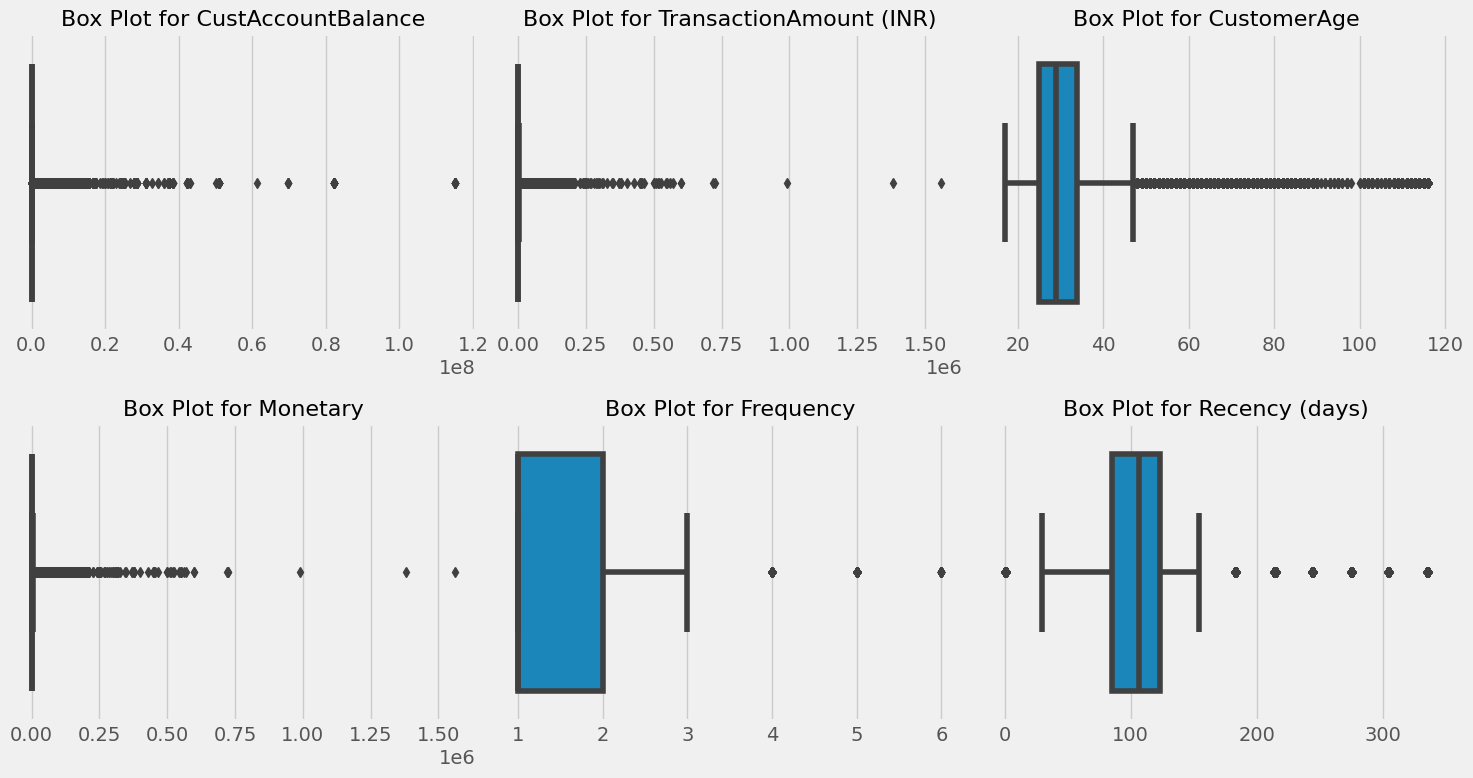

In [34]:
columns = ['CustAccountBalance', 'TransactionAmount (INR)', 'CustomerAge', 'Monetary', 'Frequency', 'Recency (days)']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i, column in enumerate(columns):
    sns.boxplot(x=df[column], ax=axes[i])
    axes[i].set_title(f'Box Plot for {column}', fontsize=16)
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

The above box plots show that there are outliers that must be dropped to ease clustering.

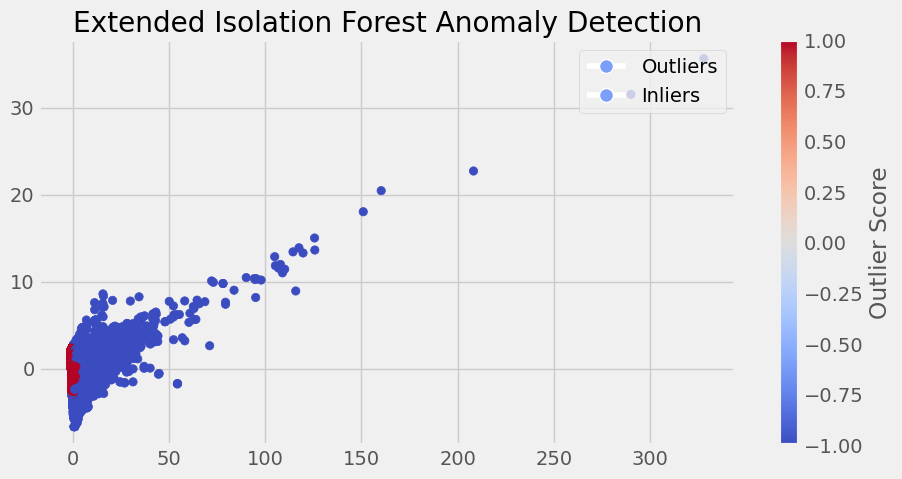

In [35]:
# Standardize the data
scaler = StandardScaler()
df_scaled= scaler.fit_transform(data)
data_scaled = pd.DataFrame(df_scaled)
data_scaled.columns = data.columns

# Apply PCA to reduce dimensionality 
pca = PCA(n_components=2) # Reduced to 2 components for visualization
data_pca = pca.fit_transform(data_scaled)

# Creating the Extended Isolation Forest model
clf = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)
clf.fit(data_pca)

# Predicting outliers (anomalies)
outlier_predictions = clf.predict(data_pca)

# Visualizing the results
plt.figure(figsize=(10, 5))
scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=outlier_predictions, cmap='coolwarm')
plt.title("Extended Isolation Forest Anomaly Detection")
legend_labels = {-1: 'Outliers', 1: 'Inliers'}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(0.2), markersize=10, label=legend_labels[label]) for label in legend_labels]
plt.legend(handles=handles, loc='upper right')
cbar = plt.colorbar()
cbar.set_label('Outlier Score')

In the above figure:



Data points labeled as -1 are considered outliers.

Data points labeled as 1 are considered inliers.

In [36]:
def remove_outliers(dataframe, col):
    q1 = dataframe[col].quantile(0.25)
    q3 = dataframe[col].quantile(0.75)
    iqr = q3 - q1
    min_val = q1 - 1.5 * iqr
    max_val = q3 + 1.5 * iqr
    dataframe=dataframe[(dataframe[col]< max_val) & (dataframe[col]> min_val)]
    return dataframe

In [37]:
data =remove_outliers(data, data.columns)

Removing outliers.

In [38]:
data .isna().sum()

CustGender                      0
CustAccountBalance         130657
TransactionAmount (INR)    105784
CustomerAge                 55046
Monetary                    99030
Frequency                    5988
Recency (days)             252155
dtype: int64

In [39]:
data .dropna(inplace=True)

Dropping null values.

In [40]:
data.isna().sum()

CustGender                 0
CustAccountBalance         0
TransactionAmount (INR)    0
CustomerAge                0
Monetary                   0
Frequency                  0
Recency (days)             0
dtype: int64

Scaling the data.

In [41]:
scaler = StandardScaler()
df_scaled= scaler.fit_transform(data)
df_scaled.shape

(532737, 7)

In [42]:
data_scaled = pd.DataFrame(df_scaled)
data_scaled.columns = data.columns
data_scaled

CustGender  CustAccountBalance  TransactionAmount (INR)  CustomerAge  \
0         0.601639           -0.693140                 0.639612     1.382344   
1         0.601639           -0.034138                 3.063686    -1.011582   
2         0.601639            0.613869                -0.876373     0.356376   
3         0.601639           -0.417732                -0.176275    -1.011582   
4         0.601639           -0.789756                -0.896028    -1.011582   
...            ...                 ...                      ...          ...   
532732    0.601639           -0.540553                 0.436980    -0.156609   
532733    0.601639           -0.766596                 1.750333    -0.840588   
532734    0.601639           -0.528697                 0.497734    -0.498598   
532735    0.601639            0.200141                -0.108017    -0.840588   
532736    0.601639           -0.436735                 0.856896     1.553339   

        Monetary  Frequency  Recency (days)  
0       2.962969   1.199002        0.764287  
1       2.060444   1.199002       -0.828428  
2       2.060444   1.199002       -0.828428  
3      -0.384442   1.199002        0.339563  
4      -0.384442   1.199002        0.339563  
...          ...        ...             ...  
532732  0.050067  -0.606032       -0.509885  
532733  1.035152  -0.606032       -0.509885  
532734  0.095636  -0.606032       -0.509885  
532735 -0.358709  -0.606032       -0.509885  
532736  0.365026  -0.606032       -0.509885  

[532737 rows x 7 columns]

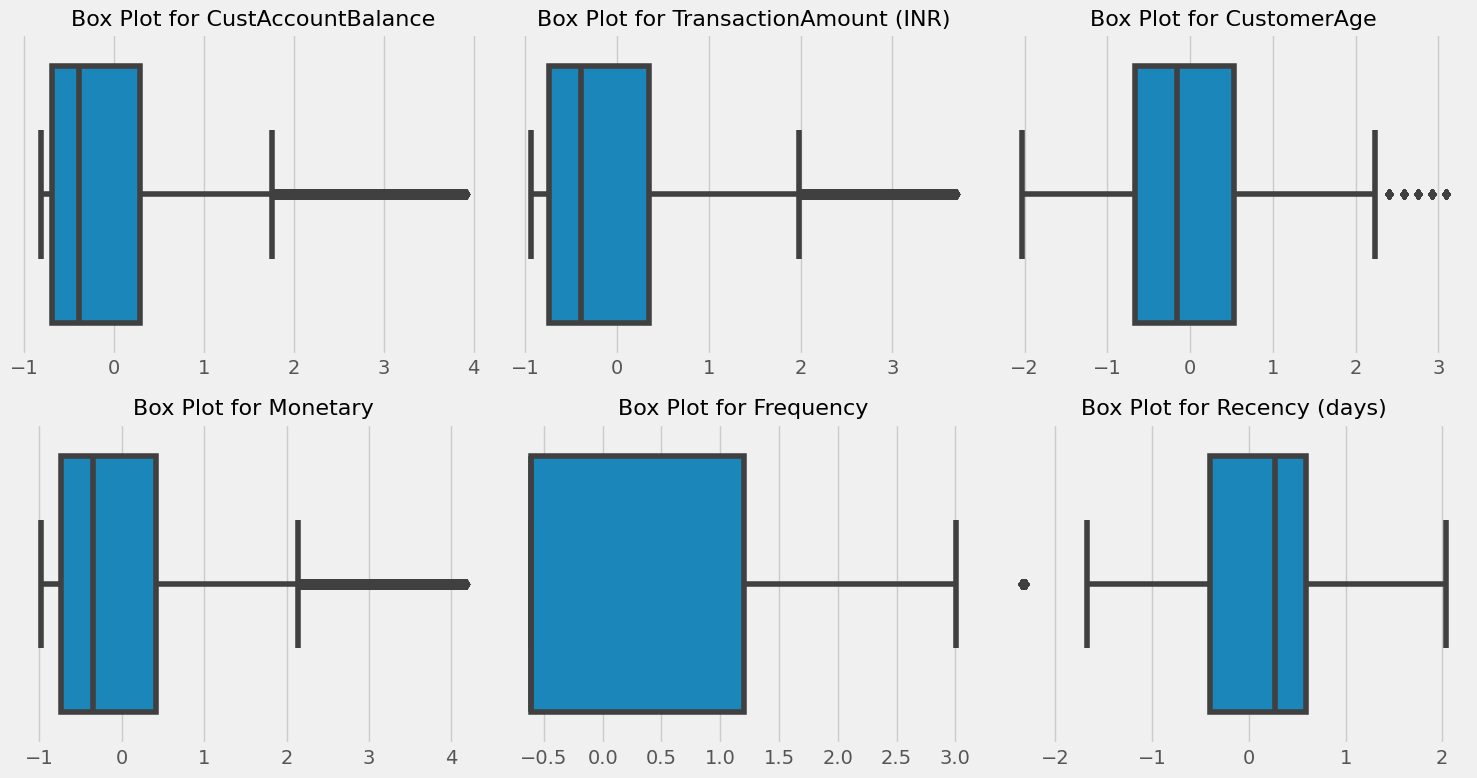

In [43]:
columns = ['CustAccountBalance', 'TransactionAmount (INR)', 'CustomerAge', 'Monetary', 'Frequency', 'Recency (days)']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i, column in enumerate(columns):
    sns.boxplot(x=data_scaled[column], ax=axes[i])
    axes[i].set_title(f'Box Plot for {column}',fontsize=16)
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

As shown above , outliers have been dropped.

# Clustering

C:\Users\96279\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\96279\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\96279\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\96279\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

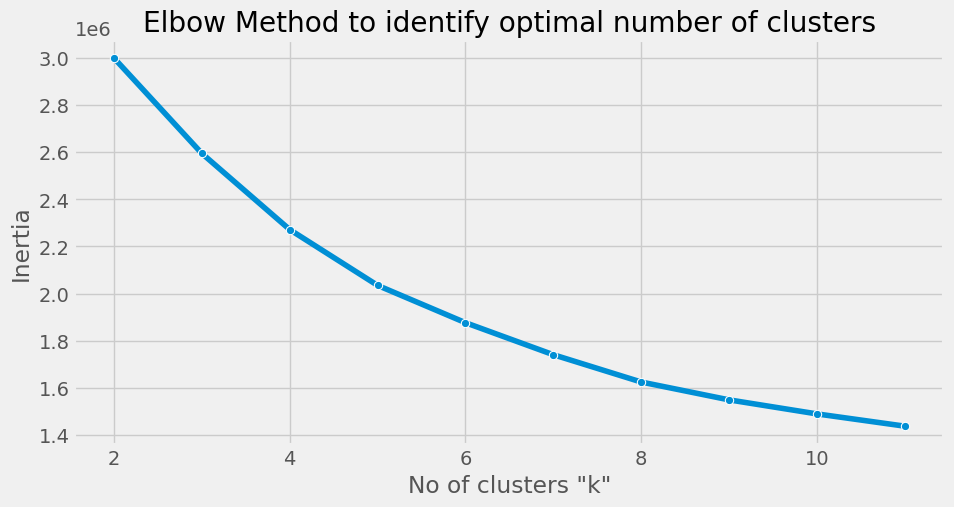

In [44]:
kmeans_set = {"init":"random", "max_iter":300, "random_state":42}
ssd = []
range_n_clusters = range(2,12)
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters,**kmeans_set)
    kmeans.fit(data_scaled)
    
    ssd.append(kmeans.inertia_)
    
ig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(y=ssd, x=range_n_clusters, marker='o',ax=ax )
plt.title('Elbow Method to identify optimal number of clusters')
plt.xlabel('No of clusters "k"')
plt.ylabel('Inertia')
plt.show();

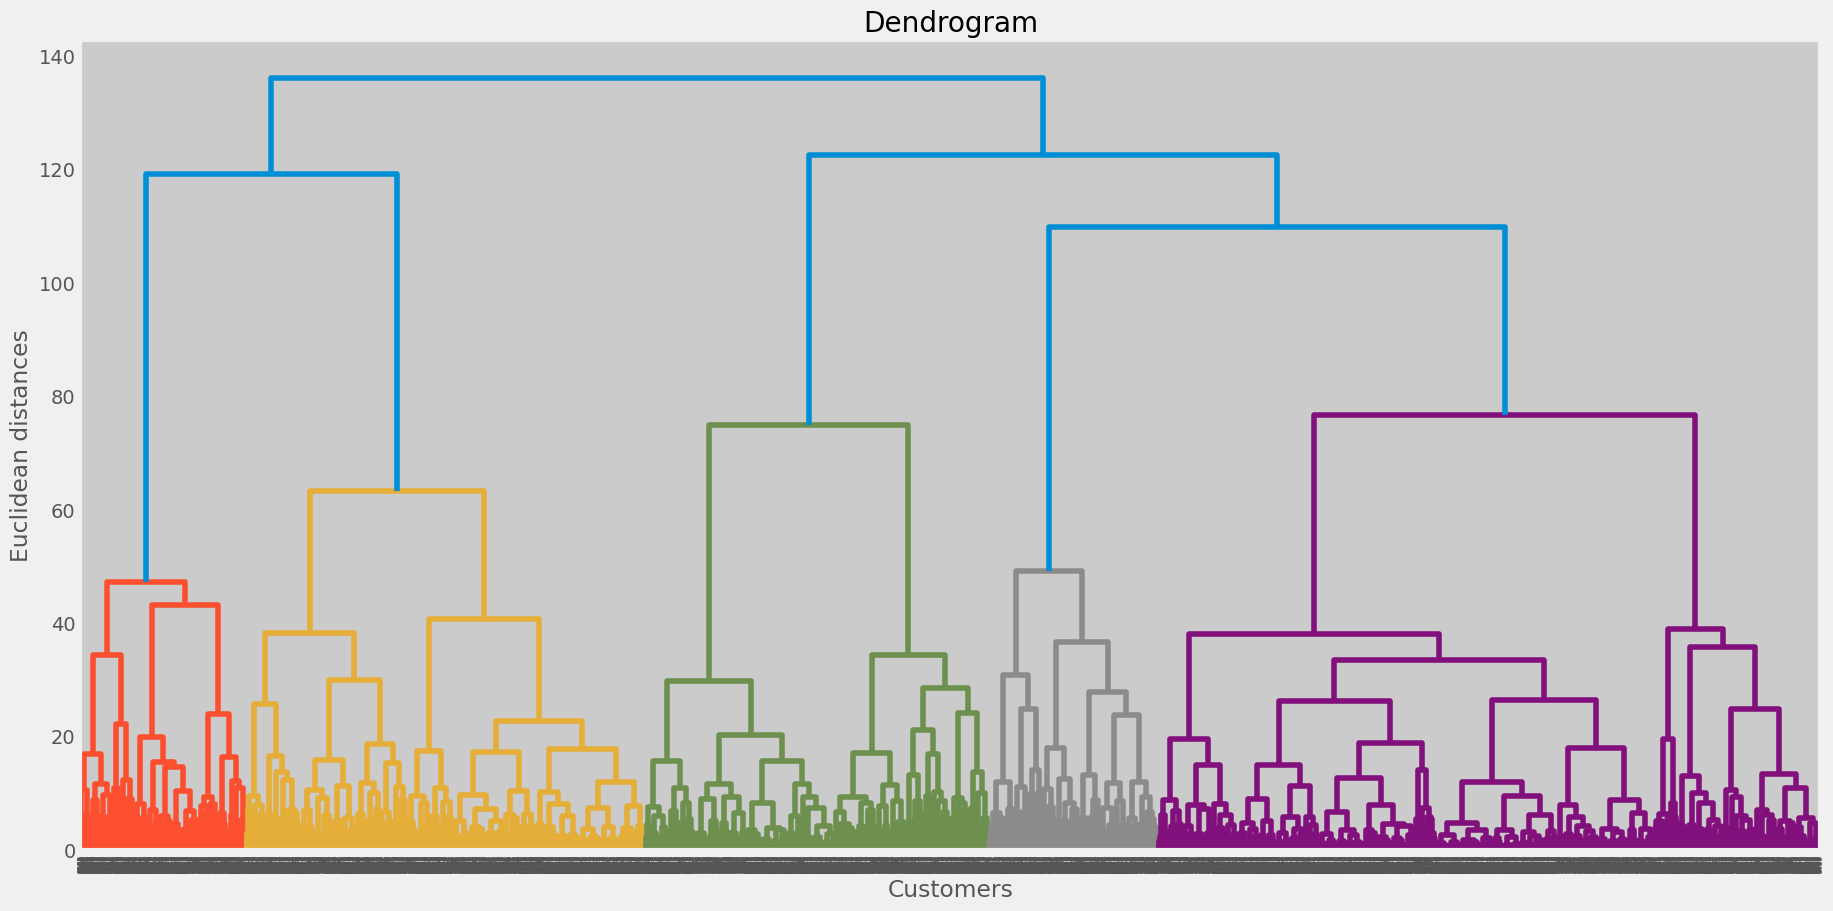

In [45]:
linkage_matrix = hierarchy.linkage(data_scaled.iloc[:10000, :], method='ward')

plt.figure(figsize=(20, 10))
dendrogram = hierarchy.dendrogram(linkage_matrix)
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

As shown above , 6 clusters are going to be used .

C:\Users\96279\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


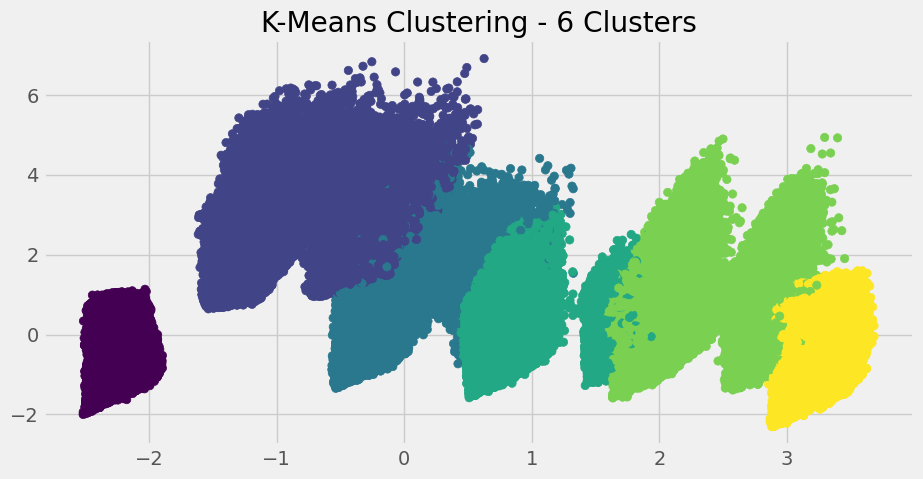

In [46]:
kmeans = KMeans(n_clusters=6, random_state=42)
cluster_labels = kmeans.fit_predict(data_scaled)

# Adding the cluster labels to the DataFrame
data_scaled['Cluster'] = cluster_labels

unique_clusters = set(cluster_labels)
n_clusters = len(unique_clusters)

# Visualizing the clusters, using PCA for dimensionality reduction:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 5))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title(f"K-Means Clustering - {n_clusters} Clusters")
plt.show()

In [47]:
import plotly.graph_objects as go
import plotly.express as px
attributes = data_scaled.columns[:7]
colors=['purple','yellow','red','blue','magenta','green']
cluster=['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6']

fig = go.Figure()
for index in range(0,6):
    fig.add_trace(go.Scatterpolar(r=np.mean(data_scaled.loc[data_scaled['Cluster'] == index, attributes]),
                                  theta=attributes,
                                  fill='toself',
                                  fillcolor=colors[index],
                                  opacity=0.5,
                                  name=cluster[index]))
    
fig.update_layout(polar=dict(radialaxis=dict(visible=True)),showlegend=True,
                  title="Radar plot - Cluster attributes")
fig.show()


C:\Users\96279\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning:

In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'

C:\Users\96279\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning:

In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'

C:\Users\96279\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning:

In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'

C:\Users\96279\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3430: F

Cluster 1: represents  male customers who have low TransactionAmount,
            low CustomerAge, low Monetary and Frequency, high CustAccountBalance, and high Recency. 


Cluster 2: represents female customers who have high TransactionAmount, high CustomerAge, high Monetary and Frequency, low CustAccountBalance and low Recency.

Cluster 3 : represents female customers who have high TransactionAmount, high CustomerAge, high Monetary , low Frequency, low CustAccountBalance, and low Recency.

Cluster 4 : represents male customers who have low TransactionAmount, low CustomerAge, high Monetary , high Frequency, low CustAccountBalance, and low Recency.

Cluster 5 : represents male customers who have low TransactionAmount, high CustomerAge, low Monetary , low Frequency, low CustAccountBalance, and medium Recency.

Cluster 6 : represents customers who have low TransactionAmount, medium CustomerAge, low Monetary , low Frequency, high CustAccountBalance, and low Recency.

In [48]:
data = {'Gender': ['M', 'F', 'F', 'M','M','-'], 
        'TransactionAmount': ['low', 'high', 'high', 'low','low','low'],
        'CustomerAge' :['low','high','high','low','high','mid-aged'],
        'Monetary' :['low','high','high','high','low','low'],
        'Frequency' : ['low','high','low','high','low','low'],
        'CustAccountBalance':['high','low','low','low','low','high'],
        'Recency':['high','low','low','low','medium','low']} 
  
df = pd.DataFrame(data, index=['cluster 1', 
                               'cluster 2', 
                               'cluster 3', 
                               'cluster 4',
                              'cluster 5',
                              'cluster 6']) 
df

Gender TransactionAmount CustomerAge Monetary Frequency  \
cluster 1      M               low         low      low       low   
cluster 2      F              high        high     high      high   
cluster 3      F              high        high     high       low   
cluster 4      M               low         low     high      high   
cluster 5      M               low        high      low       low   
cluster 6      -               low    mid-aged      low       low   

          CustAccountBalance Recency  
cluster 1               high    high  
cluster 2                low     low  
cluster 3                low     low  
cluster 4                low     low  
cluster 5                low  medium  
cluster 6               high     low

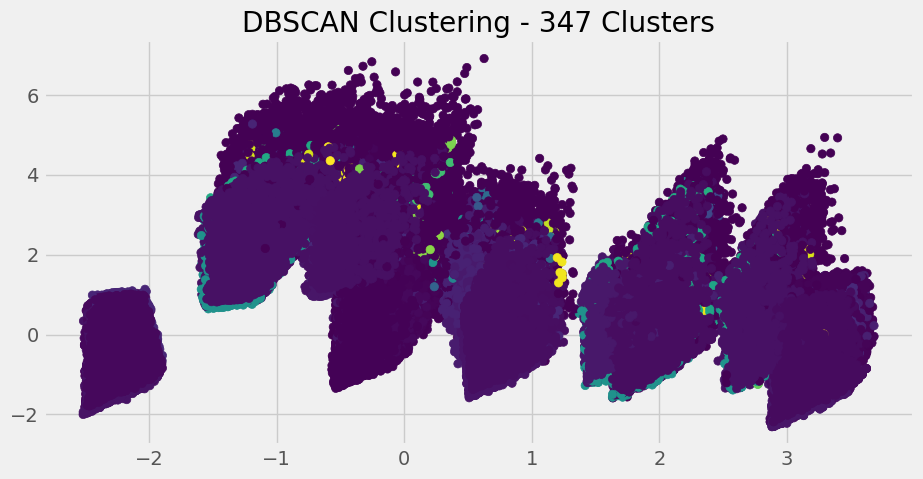

In [51]:
dbscan = DBSCAN(eps=0.5, min_samples=1000)
cluster_labels = dbscan.fit_predict(data_scaled)

# Adding the cluster labels to the DataFrame
data['Cluster'] = cluster_labels

unique_clusters = set(cluster_labels)
n_clusters = len(unique_clusters)

# Visualizing the clusters, using PCA for dimensionality reduction:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 5))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title(f"DBSCAN Clustering - {n_clusters} Clusters")
plt.show()
